# Задача 2

**<span style="color:red">Примечание:</span>** рекомендую смотреть этот ноутбук локально, тк гитхаб не отображает картинки из папки, на которых изображены виды задач и их графики на бумаге

In [1]:
from copy import copy
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns

## Покажем, что, если алгоритм сходится, то он сходится к решению задачи ЛП

Из параграфа 16 знаем, что для доказательства требуемого достаточно показать, что решение $F(x, x_s, y, y_x, \mu)$ для $\mu \rightarrow 0$ эквивалентно решению $\max c^Tx + \mu \sum\limits_{j}log{x_j} + \mu \sum\limits_{i} log{x_{s,i}}$ при условии $Ax + x_s = b$

Для этого рассмотрим функцию Лагранжа, которая в нашем случае имеет вид

$L(x, x_s, y) = c^Tx + \mu \sum\limits_{j}log{x_j} + \mu \sum\limits_{i} log{x_{s,i}} + y^T(b-Ax-x_s)$

Необходимые условия первого порядка для оптимальности:

$\frac{\partial L}{\partial x_j} = c_j + \frac{\mu}{x_j} - \sum\limits_{i}y_ia_{i,j} = 0 $

$\frac{\partial L}{\partial x_{s, i}} = \frac{\mu}{x_{s, i}} - y_i = 0 $

$\frac{\partial L}{\partial y_j} = b_i - \sum\limits_{i}a_{i,j}x_j + x_{s, i} = 0 $

Что в матричной форме имеет вид

$A^Ty - \mu X^{-1}e=c$

$y = \mu X_s^{-1}e$

$Ax+x_s=b$

Введем обозначение $y_s = \mu X^{-1}e$ и перепишем систему:

$Ax + w = b$

$A^Ty - y_s = c$

$y_s = \mu X^{-1}e$

$y = \mu X_s^{-1}e$

Домножим третье уравнение системы на $X$ и четверое на $X_s$, то получим

$Ax + w = b$

$A^Ty - y_s = c$

$X Y_s e= \mu e$

$X_s Y e= \mu e$

Притом переменные $y$ и $y_s$ - перменные двойственной задачи

Однако в случае линейных ограничений точка x^* является точкой искомой точкой, если для нее выполнены необходимые условия и $\xi^THf(x^*)\xi < 0$, где $Hf$ - матрица вторых производных.

Найдем матрицу вторых производных функции 

$f(x, w) = c^Tx + \mu \sum\limits_{j}log{x_j} + \mu \sum\limits_{i} log{x_{s,i}}$

$\frac{\partial^2 f}{\partial x_j^2} = -\frac{\mu}{x_j^2}$

$\frac{\partial^2 f}{\partial x_{s, i}^2} = -\frac{\mu}{x_{x, i}^2}$

А смешанные производные равны нулю

А значит возможно не более одной точки, и если такая точка существует, то она является глобальным  максимумом. (Это следует из факта выше и того, что марица вторых производных отрицательна, если соотв число не 0)

То есть если алгоритм сходится, то он сходится к оптимальной точке

## Демпфированный метод Ньютона

Из параграфа 17:

Хотим найти $\Delta x, \Delta x_s, \Delta y, \Delta y_s$, что $(x + \Delta x, x_s + \Delta x_s, y + \Delta y, y_s + \Delta y_s)$ лежала бы достаточно близко к центральному пути.

$Ax + w = b$

$A^Ty - y_s = c$

$X Y_s e= \mu e$

$X_s Y e= \mu e$

Тогда

$A \Delta x + \Delta x_s = b - Ax - x_s = \rho$

$A^T \Delta y - \Delta y_s = c - A^Ty + y_s = \sigma$

$Y_s \Delta x + X \Delta y_s + \Delta X \Delta Y_s e = \mu e - X Y_s e$

$X_s \Delta y + Y \Delta x_s + \Delta Y \Delta X_s e = \mu e - Y X_s e$

Эту систему можно решить методом Ньютона

Метод Ньютона никак не регулирует неотрицательность полученной точки, поэтому нам нужно выбрать такой параметр $\theta$, чтобы на каждом шагу было верно $x_j + \theta \Delta x_j > 0$, что эквивалентно $\frac{1}{\theta} > -\frac{\Delta x_j}{x_j}$ и это должно быть верно для каждой компоненты $\xi$, то есть

$\frac{1}{\theta} = \max\limits_{i, j}\{-\frac{\Delta x_j}{x_j}, -\frac{\Delta x_{s, i}}{x_{s, i}}, -\frac{\Delta y_i}{y_i},-\frac{\Delta y_{s, j}}{y_{s, j}}\}$

Отсюда $\theta = r\min((\max\limits_{i, j}\{-\frac{\Delta x_j}{x_j}, -\frac{\Delta x_{s, i}}{x_{s, i}}, -\frac{\Delta y_i}{y_i},-\frac{\Delta y_{s, j}}{y_{s, j}}\})^{-1}, 1)$, r - число меньшее 1, необходимое для того, чтобы $\theta$ всегда был меньше 1

In [2]:
def is_optimal(rho, sigma, gamma, eps):
    return np.sum(np.abs(rho)) < eps and np.sum(np.abs(sigma)) < eps and gamma < eps


def is_out_of_border(x, y, abs_coordinate_border):
    return np.max(x) > abs_coordinate_border or np.max(y) > abs_coordinate_border


def solve_path_following_method(A, b, c, delta=0.1, abs_coordinate_border=1e9, eps=1e-9, r=0.99, iters=100):
    x = np.ones(len(A.T))
    xs = np.ones(len(A))
    y = np.ones(len(A))
    ys = np.ones(len(A.T))
    cur_coord_vector = np.concatenate((x, xs, y, ys))
    rho = b - A @ x - xs
    sigma = c - A.T @ y + ys
    gamma = ys.T @ x + y.T @ xs
    mu = delta * gamma / sum(A.shape)
    
    cur_step = 0
    points = [x.copy()]
    mus = [copy(mu)]
    
    while not is_optimal(rho, sigma, gamma, eps) and not is_out_of_border(x, y, abs_coordinate_border) and cur_step < iters:
        # порядок переменных в системе как в F: x, xs, y, ys
        row1 = np.concatenate((A, np.eye(len(A)), np.zeros((len(A), len(A))), np.zeros((len(A), len(A.T)))), axis=-1)
        row2 = np.concatenate((np.zeros((len(A.T), len(A.T))), np.zeros((len(A.T), len(A))), 
                               A.T, -np.eye(len(A.T))), axis=-1)
        row3 = np.concatenate((np.diag(ys), np.zeros((len(A.T), len(A))), 
                               np.zeros((len(A.T), len(A))), np.diag(x)), axis=-1)
        row4 = np.concatenate((np.zeros((len(A), len(A.T))), np.diag(y), np.diag(xs), np.zeros((len(A), len(A.T)))), axis=-1)
        system_matrix = np.concatenate((row1, row2, row3, row4))
        system_bias = np.concatenate((rho, sigma, 
                                      mu * np.ones((len(A.T))) - np.diag(x) @ np.diag(ys) @ np.ones((len(A.T))), 
                                      mu * np.ones((len(A))) - np.diag(y) @ np.diag(xs) @ np.ones(len(A))))
        solution = np.linalg.solve(system_matrix, system_bias)
        delta_x = solution[: len(A.T)]
        delta_xs = solution[len(A.T): len(A.T) + len(A)]
        delta_y = solution[len(A.T) + len(A): len(A.T) + len(A) + len(A)]
        delta_ys = solution[len(A.T) + len(A) + len(A):]
        step = r * min(1 / max(-solution / cur_coord_vector), 1)
        x += step * delta_x
        xs += step * delta_xs
        y += step * delta_y
        ys += step * delta_ys
        
        points.append(x.copy())
        mus.append(copy(mu))
        cur_step += 1
        
        cur_coord_vector = np.concatenate((x, xs, y, ys))
        rho = b - A @ x - xs
        sigma = c - A.T @ y + ys
        gamma = ys.T @ x + y.T @ xs
        mu = delta * gamma / sum(A.shape)
        
    return x, np.array(points), np.array(mus)

## Решим задачу ЛП

На примере первого примера с сайта https://www.matburo.ru/Examples/Files/LP_Graph2.pdf

Задача
<img src="photos/task2_1.png">

Вид в канонической форме:

$x - 2y \rightarrow \max$

$-5x - 3y + x_{s1} = -30$

$x - y + x_{s2} = 3$

$-3x + 5y + x_{s3} = 15$

$x, y \geq 0, x_s \geq 0$

Графическое решение - нижняя точка $C = (\frac{39}{8}, \frac{15}{8})$
<img src="photos/task2_2.png">
Проверим наш алгоритм

In [3]:
def round_num(num, precision=3):
    degree = 10**precision
    return round(num * degree) / degree

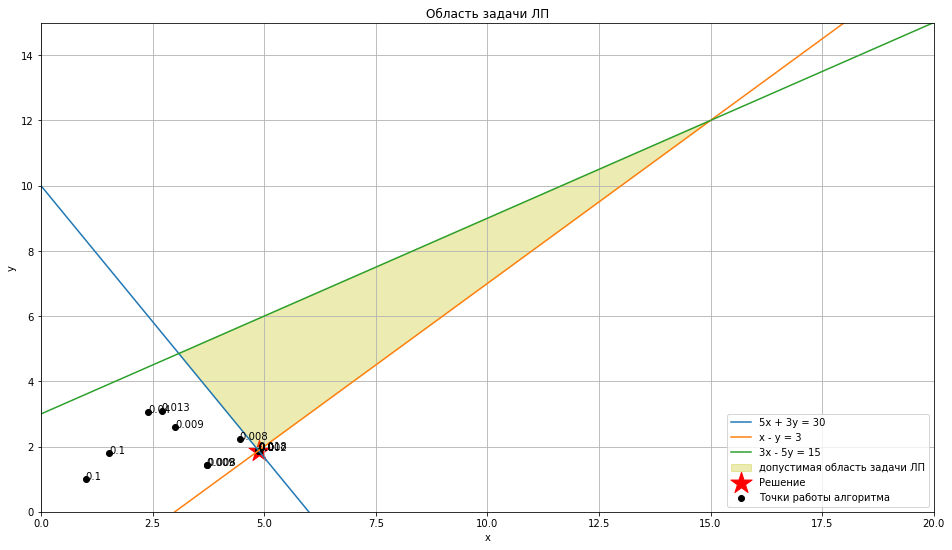

In [4]:
A = np.array([[-5, -3], [1, -1], [-3, 5]])
b = np.array([-30, 3, 15])
c = np.array([1, -2])

_, observed_points, mus = solve_path_following_method(A, b, c)

grid = np.linspace(-1, 20, 100)

plt.figure(figsize=(16, 9))
plt.plot(grid, (30 - 5 * grid) / 3, label=r'5x + 3y = 30')
plt.plot(grid, grid - 3, label=r'x - y = 3')
plt.plot(grid, (15 + 3 * grid) / 5, label=r'3x - 5y = 15')
plt.fill([15, 39 / 8, 105 / 34], [12, 15 / 8, 165 / 34], alpha=0.3, c='y', label='допустимая область задачи ЛП')
plt.scatter([39/8], [15/8], label='Решение', marker='*', s=500, c='r')
plt.scatter(observed_points[:, 0], observed_points[:, 1], label='Точки работы алгоритма', c='black')
for i, mu in enumerate(mus):
    plt.annotate(str(round_num(mu)), (observed_points[i][0], observed_points[i][1]))
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((0, 20))
plt.ylim((0, 15))
plt.title('Область задачи ЛП')
plt.legend()
plt.show()

In [5]:
print('Значения mu = ['+ ', '.join(map(str, mus)) + ']')
print('Рассмотренные точки:')
print(observed_points)

Значения mu = [0.1, 0.1, 0.040419658543931085, 0.013235451474664314, 0.008693795523597713, 0.008590941493697627, 0.008372602899162744, 0.008342577097601282, 0.018498463794390543, 0.0023099213775217274, 0.00033757664439080474, 3.693145329807046e-05, 4.025558950592586e-06, 4.3878594768702015e-07, 4.7827668321000344e-08, 5.2132158470141595e-09, 5.682405273245705e-10, 6.193821747837826e-11]
Рассмотренные точки:
[[1.         1.        ]
 [1.53489588 1.78927196]
 [2.39986578 3.04674403]
 [2.70704412 3.09522368]
 [3.01117291 2.59645174]
 [3.71506468 1.4318851 ]
 [3.72662538 1.42220655]
 [4.45465412 2.21824157]
 [4.8663736  1.90526002]
 [4.88166826 1.88324197]
 [4.87532222 1.87554303]
 [4.87503127 1.87505598]
 [4.87500338 1.87500608]
 [4.87500037 1.87500066]
 [4.87500004 1.87500007]
 [4.875      1.87500001]
 [4.875      1.875     ]
 [4.875      1.875     ]]


**Вывод:** метод действительно работает. 

Касательно условий останова в случае ограниченной задачи ЛП:
* Можно останавливаться по числу итераций (самый очевидный вариант)
* Можно останавливаться по норме разности текущей точки и предыдущей (как для переменных $x, x_s$ в прямой задаче, так и для переменных $y, y_s$ в обратной) 
* Можно останавливаться при достижении $\mu$ некоторого значения
* Можно останавливаться как сказано в книге: когда $\Vert \rho \Vert < \epsilon \wedge \Vert \sigma \Vert < \epsilon \wedge \gamma < \epsilon$

## Решим неограниченную задачу ЛП

На примере последнего примера с сайта https://www.matburo.ru/Examples/Files/LP_Graph7.pdf

Задача
<img src="photos/task2_3.png">

Вид в канонической форме:

$x + y \rightarrow \max$

$ x - 2y + x_{s1} = 30$

$ 5x - y + x_{s2} = 25$

$x, y \geq 0, x_s \geq 0$

По рисунку очевидно, что область не ограничена:

<img src="photos/task2_4.png">
Проверим наш алгоритм

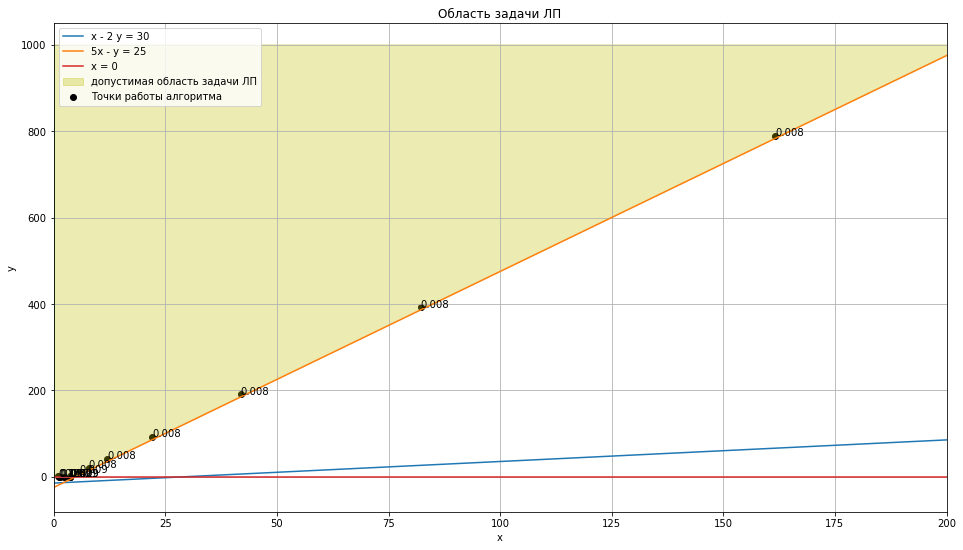

In [6]:
A = np.array([[1, -2], [5, -1]])
b = np.array([30, 25])
c = np.array([1, 1])

top_lim = 1000
_, observed_points, mus = solve_path_following_method(A, b, c)

grid = np.linspace(-1, 200, 100)

plt.figure(figsize=(16, 9))
plt.plot(grid, (grid - 30) / 2, label=r'x - 2 y = 30')
plt.plot(grid, 5 * grid - 25, label=r'5x - y = 25')
plt.plot([0, 0], [0, top_lim])
plt.plot([0, grid[-1]], [0, 0], label='x = 0')
# чтобы не падал matplotlib из-за большого размера фигуры 
small_points_idc = (observed_points < 1000).all(1)
plt.scatter(observed_points[small_points_idc][:, 0], 
            observed_points[small_points_idc][:, 1], 
            label='Точки работы алгоритма', c='black')
plt.fill([0, 0, 5, (top_lim + 25) / 5], [1000, 0, 0, top_lim], alpha=0.3, c='y', label='допустимая область задачи ЛП')
for i, mu in enumerate(mus[small_points_idc]):
    plt.annotate(str(round_num(mu)), (observed_points[i][0], observed_points[i][1]))
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((0, 200))
# чтобы не падал matplotlib из-за большого размера фигуры 
#plt.ylim((0, 10))
plt.title('Область задачи ЛП')
plt.legend()
plt.show()

In [7]:
print('Значения mu = ['+ ', '.join(map(str, mus)) + ']')
print('Рассмотренные точки:')
print(observed_points)
print('Число рассмотренных точек {}'.format(len(observed_points)))

Значения mu = [0.1, 0.1, 0.05746146895820639, 0.04151734244212947, 0.021073234248344574, 0.009685452984523424, 0.008756459170130895, 0.008745736283648898, 0.008745285817968846, 0.008259692373830911, 0.008237902592131773, 0.008218679289506129, 0.008187099298203198, 0.008178255998707704, 0.008176241190187802, 0.008176086521579721, 0.008176075644437232, 0.008176075429604095, 0.008176075423664398, 0.008176075423540832, 0.008176075423538346, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298, 0.008176075423538298]
Рассмотренные точки:
[[1.00000000e+00 1.00000000e+00]
 [1.19067759e+00 1.00000000e-02]
 [1.42920446e+00 9.46044820e-03]
 [2.30462210e+00 1.52361761e-02]
 [3.57816266e+00 2.88440557e-02]
 [3.71347069e+00 6.18272418e-02]
 [3.728466

**Вывод:** Как верно сказано в книжке, всегда нужно устанавливать какую-то верхнюю границу на нормы векторов из прямой и обратной задачи. Это значение в идеале должно быть подобрано таким образом, чтобы только вектора неограниченных задачи ЛП превышали по норме это число, а ветора ограниченных задач к этой норме не приближались даже близко. В таком случае при достижении такой нормы нужно останавливать решение задачи с вердиктом неограниченности задачи ЛП.

Также в этом эксперименте есть два интересных наблюдения:

* Нам понадобилось всего 36 точек, чтобы выйти за границу нормы $10^9$, что означает, что с момента попадания на границу прямой, вдоль которой осуществляется бесконечное возрастание, точки начинают неверноятно быстро увеличивать свои координаты, "поднимаясь" вдоль прямой

* С момента попадания на прямую бесконечного роста наш параметр $mu$ не уменьшался - он оставался постоянным с точностью до 18-ти знаков после запятой (выводимая точность)